In [1]:
# 변수의 shape, type, value 확인
def p(var,_name="") :
    if _name != "" : print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:      print(f'Shape:{var.shape}')
        except :  pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}')

### **Import Module**

In [2]:
import tensorflow as tf

import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams["font.size"] = "8"

keras.__version__

'3.8.0'

# RNN Model Design (MNIST-RNN)

### **DataSet**

#### Load

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0   # (0~1)<-(0~255)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
ps(x_train)
ps(y_train)

<<>> Shape(60000, 28, 28)
<<>> Shape(60000,)


In [5]:
p(x_test[0:3])
p(y_test[0:3])

Shape:(3, 28, 28)
Type: <class 'numpy.ndarray'>
Values: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Shape:(3,)
Type: <class 'numpy.ndarray'>
Values: [7 2 1]


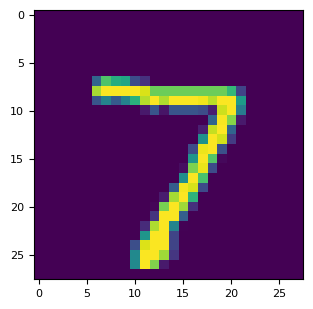

In [6]:
plt.imshow(x_test[0])
plt.show()

## Plot history

In [7]:
def plt_history(historys,names,min_acc=0.75):
    mins =[]
    title_name = ""
    for i,h in enumerate(historys):
        title_name += f"({names[i]}:{max(h['val_acc']):.3f})"
    plt.figure(figsize=(10,3))
    plt.subplot(121)

    for i,h in enumerate(historys):
        plt.plot(h['acc'], label=names[i])
        plt.plot(h['val_acc'], label=names[i]+"_val")
    plt.title("Accuracy\n"+title_name)
    plt.ylim(min_acc, 1)
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.title("loss")
    for i,h in enumerate(historys):
        plt.plot(h['loss'], label=names[i])
        plt.plot(h['val_loss'], label=names[i]+"_val")
    #plt.ylim(0.1, 1)
    plt.semilogy()
    plt.legend()
    plt.grid()

    plt.show()

In [8]:
# 주요 변수 정의
features = 28   #pixels
time_steps = 28 #lines
in_dense = 14     # 임의 값
lstm_units = 32 # 임의 값
out_dense = 10    # 출력은 숫자(0~9) 확률

## **Model-1** : Basic LSTM Model

Model: "Basic-RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 28, 14)         │           406 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,752 (26.38 KB)

 Trainable params: 6,752 (26.38 KB)

 Non-trainable params: 0 (0.00 B)

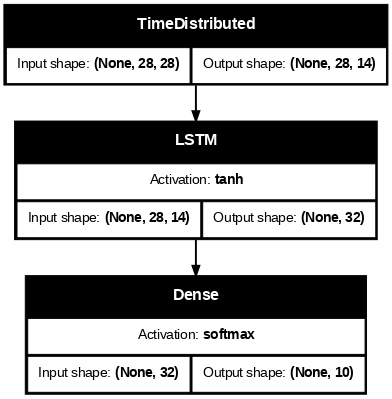

In [9]:
## Model-1 설계 : many to one 기본 모델
def model_1():
    return keras.models.Sequential([
          keras.Input(shape=(time_steps, features)),
          layers.TimeDistributed(layers.Dense(in_dense)),
          layers.LSTM(lstm_units,dropout=0.1),         # LSTM
          layers.Dense(out_dense, activation='softmax')
    ],name="Basic-RNN")

model = model_1() # Model Instance

model.summary()
keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=70)

In [10]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#### Fit

In [11]:
%%time
batch_size = 512
history_1 = model.fit(x_train, y_train,   #(60000,28,28),(60000,)
          validation_data=(x_test, y_test), #(10000,28,28),(10000,)
          batch_size=batch_size,
          epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - acc: 0.2587 - loss: 2.1153 - val_acc: 0.6628 - val_loss: 1.1012
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.7104 - loss: 0.9375 - val_acc: 0.8146 - val_loss: 0.6207
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8322 - loss: 0.5635 - val_acc: 0.8755 - val_loss: 0.4273
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8838 - loss: 0.3997 - val_acc: 0.8984 - val_loss: 0.3503
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9071 - loss: 0.3220 - val_acc: 0.9231 - val_loss: 0.2769
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9242 - loss: 0.2661 - val_acc: 0.9278 - val_loss: 0.2495
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9305 - loss: 0.2428 - val_acc: 0.9387 - val_loss: 0.2140
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9406 - loss: 0.2097 - val_acc: 0.9450 - val_loss: 0.1928
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - a

Wall time: 22.6 s


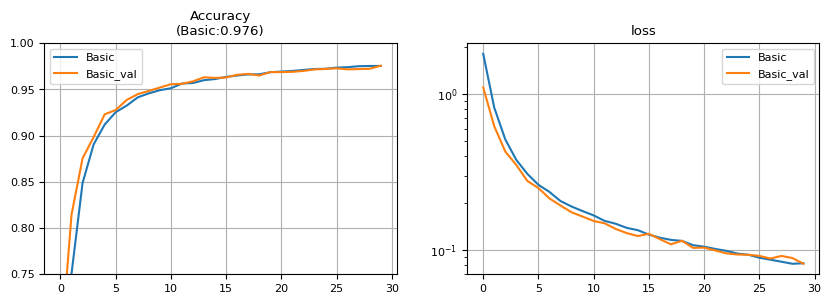

In [12]:
titles=["Basic"]
plt_history([history_1.history],titles)

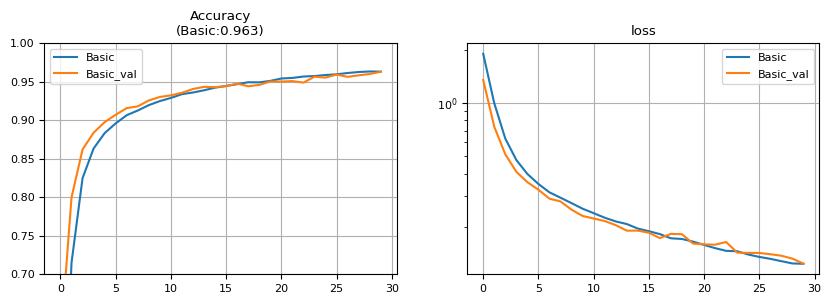

## **Model-1BN** : Basic Model + BN/LN

Model: "Basic-RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, 28, 14)         │           406 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,816 (26.62 KB)

 Trainable params: 6,816 (26.62 KB)

 Non-trainable params: 0 (0.00 B)

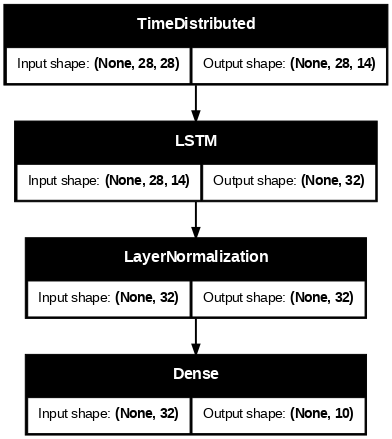

In [13]:
## Model-1 설계 : many to one 기본 모델
def model_1():
    model = keras.models.Sequential(name="Basic-RNN")
    model.add(keras.Input(shape=(time_steps, features)))
    model.add(layers.TimeDistributed(layers.Dense(in_dense)))
    model.add(layers.LSTM(lstm_units, dropout=0.1)   )
#    model.add(layers.BatchNormalization())
    model.add(layers.LayerNormalization())
    model.add(layers.Dense(out_dense, activation='softmax'))
    return model

model = model_1() # Model Instance

model.summary()
keras.utils.plot_model(model,'model.png',show_shapes=True,dpi=70)

In [14]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#### Fit

In [15]:
%%time
batch_size = 512
history_1bn = model.fit(x_train, y_train,   #(60000,28,28),(60000,)
          validation_data=(x_test, y_test), #(10000,28,28),(10000,)
          batch_size=batch_size,
          epochs=30)
# Wall time: 34.3 s

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.3137 - loss: 1.9972 - val_acc: 0.6694 - val_loss: 1.0076
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.7225 - loss: 0.8582 - val_acc: 0.8470 - val_loss: 0.5045
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8583 - loss: 0.4592 - val_acc: 0.9038 - val_loss: 0.3281
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9002 - loss: 0.3259 - val_acc: 0.9175 - val_loss: 0.2615
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9226 - loss: 0.2526 - val_acc: 0.9303 - val_loss: 0.2157
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9354 - loss: 0.2119 - val_acc: 0.9454 - val_loss: 0.1834
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9427 - loss: 0.1902 - val_acc: 0.9499 - val_loss: 0.1646
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9510 - loss: 0.1623 - val_acc: 0.9518 - val_loss: 0.1558
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - a

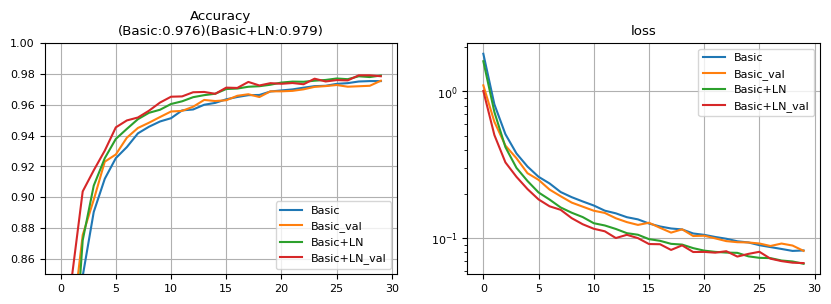

In [16]:
#titles=["Basic","Basic+BN"]
titles=["Basic","Basic+LN"]
plt_history([history_1.history,history_1bn.history],titles,0.85)

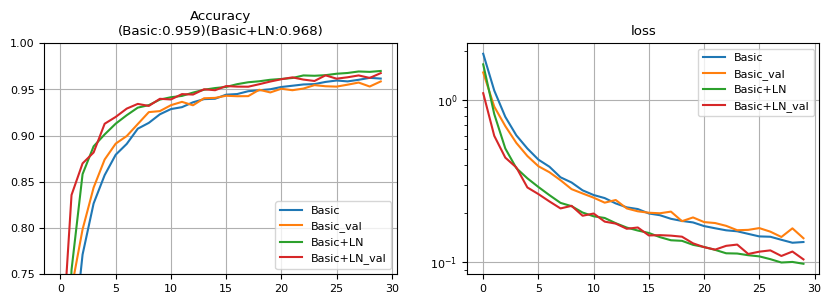

**특별히 Batch size가 작지 않으면 BN도 잘 동작하는 경우가 많음**

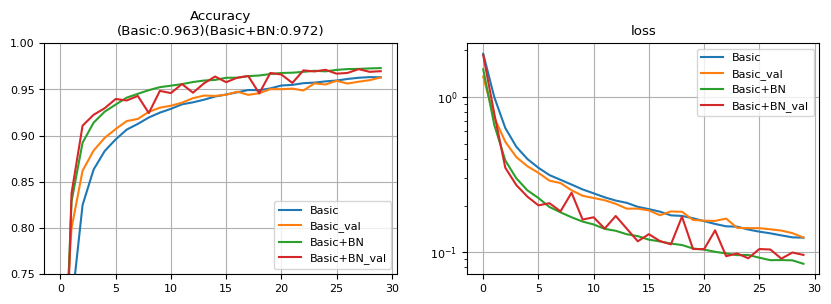

## **Model-2** : Bidirectional Model

Model: "Bidirectional-RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, 28, 14)         │           406 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        12,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,088 (51.12 KB)

 Trainable params: 13,088 (51.12 KB)

 Non-trainable params: 0 (0.00 B)

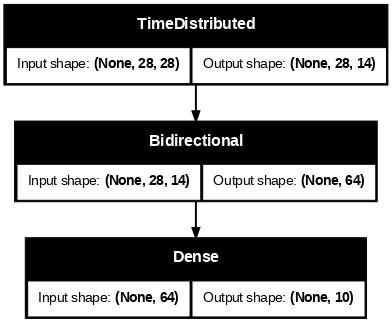

In [17]:
## Model-2 설계 : Bidirectional 추가
def model_2():
    model = keras.models.Sequential(name="Bidirectional-RNN")
    model.add(keras.Input(shape=(time_steps, features)))
    model.add(layers.TimeDistributed(layers.Dense(in_dense)))
    model.add(layers.Bidirectional(layers.LSTM(lstm_units,dropout=0.1)))
    model.add(layers.Dense(out_dense, activation='softmax'))
    return model

model = model_2()
model.summary()
keras.utils.plot_model(model,'model.png',show_shapes=True,dpi=70)


In [18]:
# model_Bi : bi-RNN
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#### Fit

In [19]:
%%time
batch_size = 512
history_2 = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - acc: 0.2938 - loss: 2.0282 - val_acc: 0.6788 - val_loss: 1.0134
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.7290 - loss: 0.8476 - val_acc: 0.8434 - val_loss: 0.4927
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8656 - loss: 0.4342 - val_acc: 0.9062 - val_loss: 0.3131
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9117 - loss: 0.2869 - val_acc: 0.9255 - val_loss: 0.2383
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9298 - loss: 0.2285 - val_acc: 0.9400 - val_loss: 0.1952
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9399 - loss: 0.1944 - val_acc: 0.9502 - val_loss: 0.1701
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9486 - loss: 0.1680 - val_acc: 0.9519 - val_loss: 0.1586
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9547 - loss: 0.1510 - val_acc: 0.9600 - val_loss: 0.1383
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/

Wall time: 33.4 s


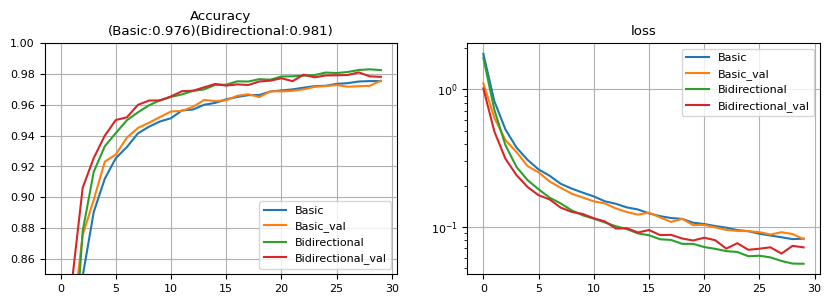

In [20]:
titles=["Basic","Bidirectional"]
plt_history([history_1.history,history_2.history],titles,0.85)

## Model-3.1 BahdanauAttentionLSTM

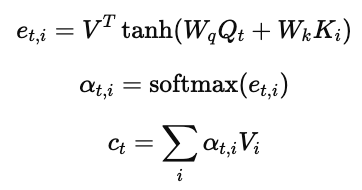

**동작 설명**  
* Attention layer는  
* **LSTM의 마지막 상태를 Query(1,hidden)로 사용 하여**
* x값(time_step, hidden)에서 정보를 처리하여 가져옴  
* 이 값으로 출력을 결정   

In [21]:
# Bahdanau Attention Layer 정의
class BahdanauAttention(layers.Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.Wq = layers.Dense(units)
        self.Wk = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)  #(bs, 1, units)
        score = self.V(tf.nn.tanh(self.Wq(query_with_time_axis) + self.Wk(values)))
        attention_weights = tf.nn.softmax(score, axis=1) #(bs, time_steps, 1)
        context_vector = tf.reduce_sum(attention_weights*values, axis=1)#(bs, units)
        return context_vector, attention_weights

def Attention_lstm_model(hidden_size, num_layers):
    in_layer = keras.Input(shape=(time_steps, features))
    x = layers.TimeDistributed(layers.Dense(in_dense))(in_layer)
    for _ in range(num_layers):
        x = layers.LSTM(hidden_size, return_sequences=True,dropout=0.1)(x)
    query = layers.Lambda(lambda t: t[:, -1, :])(x) #마지막 timestep:(bs, hidden_size)
    # Attention 적용
    attention_layer = BahdanauAttention(units=hidden_size)
    ## query로 x에서 정보를 취합
    context_vector, attn_weights = attention_layer(query, x) # Att.(Q,V(K))
    x = layers.Dropout(0.)(context_vector)
    outputs = layers.Dense(out_dense, activation='softmax')(x)
    model = keras.Model(inputs=in_layer, outputs=outputs)
    return model

# 모델 생성 및 요약 출력
model = Attention_lstm_model(hidden_size=lstm_units, num_layers=1)
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 28, 14)    │        406 │ input_layer_3[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 28, 32)    │      6,016 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, 32),      │      2,145 │ lambda[0][0],     │
│ (BahdanauAttention) │ (None, 28, 1)]    │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ bahdanau_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 10)        │        330 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,897 (34.75 KB)

 Trainable params: 8,897 (34.75 KB)

 Non-trainable params: 0 (0.00 B)

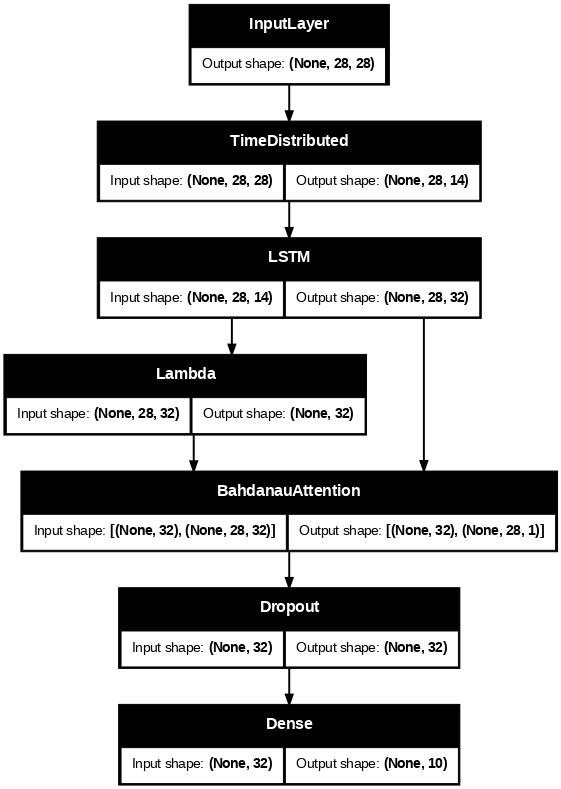

In [22]:
keras.utils.plot_model(model,show_shapes=True,dpi=70)

In [23]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#### Fit

In [24]:
%%time
batch_size = 512
history_3_1 = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.2244 - loss: 2.1590 - val_acc: 0.5665 - val_loss: 1.2880
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.6526 - loss: 1.0671 - val_acc: 0.8128 - val_loss: 0.6274
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.8345 - loss: 0.5612 - val_acc: 0.8848 - val_loss: 0.3919
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.8920 - loss: 0.3714 - val_acc: 0.9163 - val_loss: 0.2977
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9187 - loss: 0.2837 - val_acc: 0.9325 - val_loss: 0.2330
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9340 - loss: 0.2301 - val_acc: 0.9450 - val_loss: 0.1963
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9418 - loss: 0.2015 - val_acc: 0.9478 - val_loss: 0.1832
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9475 - loss: 0.1818 - val_acc: 0.9516 - val_loss: 0.1689
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - a

Wall time: 33.4 s


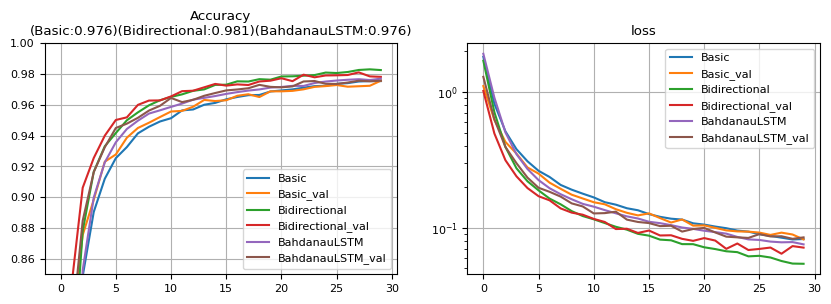

In [25]:
titles=["Basic","Bidirectional","BahdanauLSTM"]
plt_history([history_1.history,history_2.history,history_3_1.history],titles,0.85)

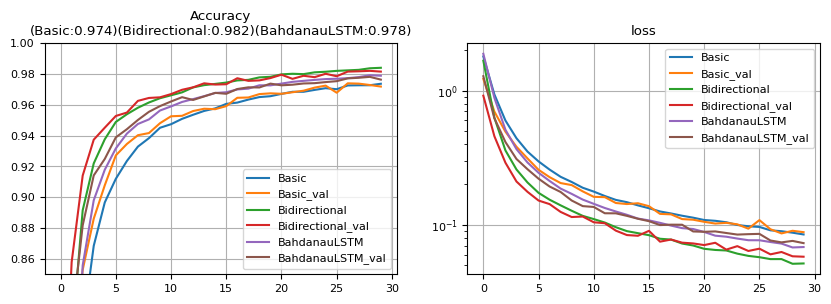

## Model-3.2 LuongAttentionLSTM

Luong Attention (Multicative or General)

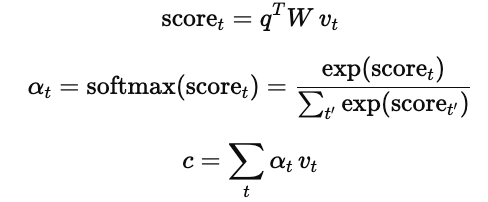

In [26]:
import tensorflow as tf

class LuongAttention(layers.Layer):
    def __init__(self, units, **kwargs):
        super(LuongAttention, self).__init__(**kwargs)
        self.W = layers.Dense(units, use_bias=False)  # value(key)에 적용할 weight
    # query: (bs, hidden), values(key): (bs, time_steps, hidden)
    def call(self, query, values):
        # values (key)에 선형변환 적용: W v_t
        transformed_values = self.W(values)  # (bs, time_steps, units)
        # query: (bs, hidden) → (bs, 1, hidden)로 reshape
        query = tf.expand_dims(query, axis=1)  # (bs, 1, hidden)
        # score = q^T (W v_t) = dot product (bs,1,hidden)·(bs,time,hidden)^T → (bs,time,1)
        score = tf.matmul(query, transformed_values, transpose_b=True)#(bs,1,time_steps)
        score = tf.transpose(score, perm=[0, 2, 1])  # (bs, time_steps, 1)
        # softmax로 attention weight 계산
        attention_weights = tf.nn.softmax(score, axis=1)  # (bs, time_steps, 1)
        # context vector 계산: Σ α_t v_t
        context_vector = tf.reduce_sum(attention_weights * values, axis=1)#(bs,hidden)
        return context_vector, attention_weights

def Attention_lstm_model(hidden_size, num_layers):
    in_layer = keras.Input(shape=(time_steps, features))
    x = layers.TimeDistributed(layers.Dense(in_dense))(in_layer)

    for _ in range(num_layers): # x:(bs, time_steps, hidden_size)
        x = layers.LSTM(hidden_size, return_sequences=True,dropout=0.1)(x)

    query = layers.Lambda(lambda t: t[:, -1, :])(x) # 마지막 time_steps을 query로 사용

    # Attention 적용
    attention_layer = LuongAttention(units=hidden_size)
    context_vector, attn_weights = attention_layer(query, x) # (Q,V(K))

    x = layers.Dropout(0.)(context_vector)
    outputs = layers.Dense(out_dense, activation='softmax')(x)

    model = keras.Model(inputs=in_layer, outputs=outputs)
    return model

model = Attention_lstm_model( hidden_size=lstm_units, num_layers=1)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 28, 14)    │        406 │ input_layer_4[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 28, 32)    │      6,016 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 32)        │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ luong_attention     │ [(None, 32),      │      1,024 │ lambda_1[0][0],   │
│ (LuongAttention)    │ (None, 28, 1)]    │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ luong_attention[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 10)        │        330 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,776 (30.38 KB)

 Trainable params: 7,776 (30.38 KB)

 Non-trainable params: 0 (0.00 B)

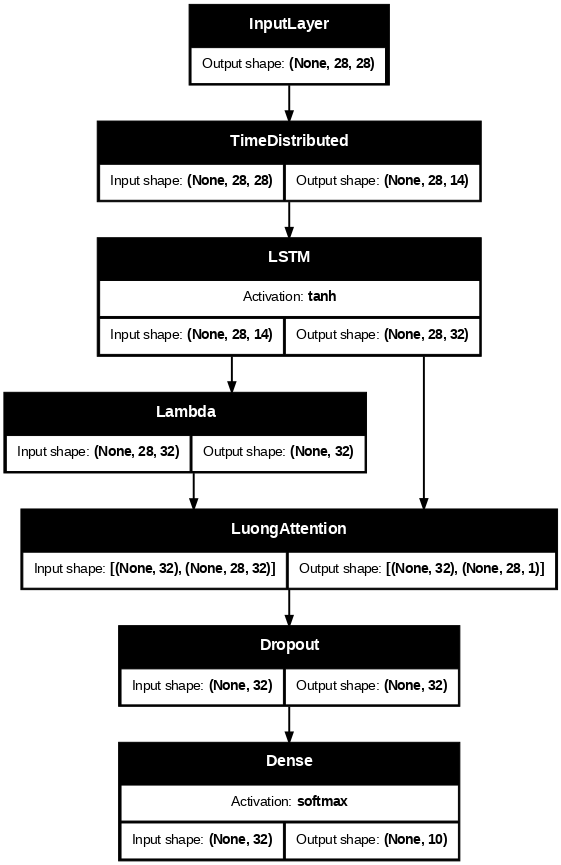

In [27]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=70)

In [28]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#### Fit

In [29]:
%%time
batch_size = 512
history_3_2 = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - acc: 0.2475 - loss: 2.1249 - val_acc: 0.6007 - val_loss: 1.2917
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.6718 - loss: 1.0950 - val_acc: 0.8234 - val_loss: 0.6275
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8302 - loss: 0.5897 - val_acc: 0.8892 - val_loss: 0.3975
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8924 - loss: 0.3820 - val_acc: 0.9136 - val_loss: 0.3088
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9181 - loss: 0.2919 - val_acc: 0.9352 - val_loss: 0.2422
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9345 - loss: 0.2390 - val_acc: 0.9442 - val_loss: 0.2067
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9414 - loss: 0.2123 - val_acc: 0.9445 - val_loss: 0.1888
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9459 - loss: 0.1931 - val_acc: 0.9534 - val_loss: 0.1662
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - a

Wall time: 33.4 s


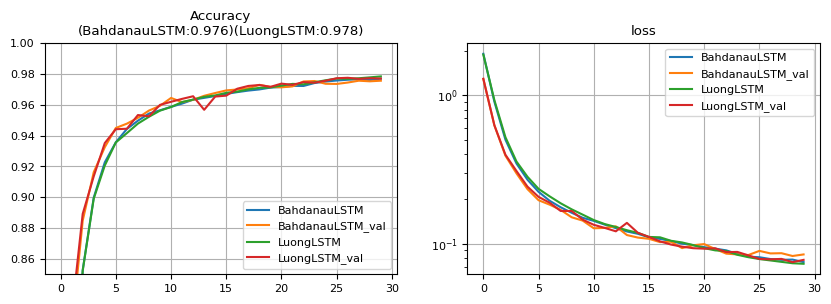

In [30]:
titles=["BahdanauLSTM","LuongLSTM"]
plt_history([history_3_1.history,history_3_2.history],titles,0.85)

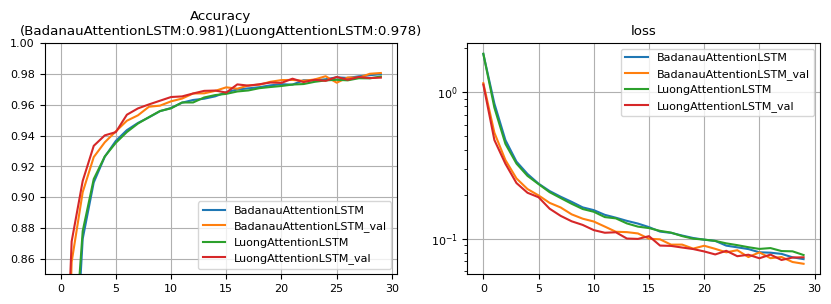

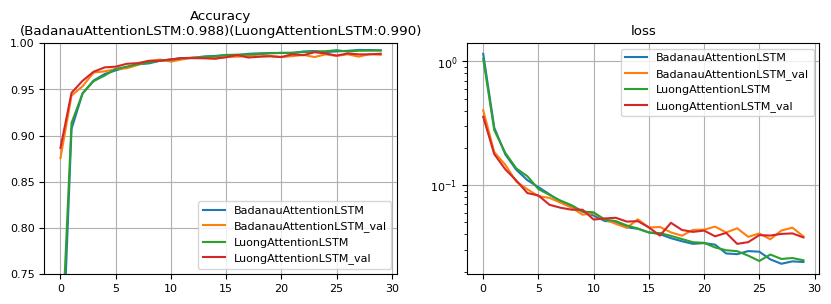

## Model-3.3 Scaled Dot-Product Attention

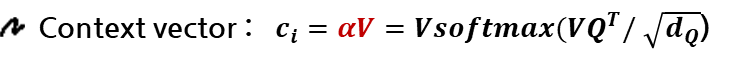

In [31]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)
    # query: (batch_size, hidden_dim), values: (batch_size, time_steps, hidden_dim)
    def call(self, query, values):
        # hidden 차원 수 (스케일링에 사용)
        d_k = tf.cast(tf.shape(query)[-1], tf.float32)
        # (bs, hidden_dim) → (bs, 1, hidden_dim)
        query_expanded = tf.expand_dims(query, axis=1)
        # (bs, 1, hidden_dim) · (bs, time_steps, hidden_dim)^T → (bs, 1, time_steps)
        score = tf.matmul(query_expanded, values, transpose_b=True) / tf.math.sqrt(d_k)
        # softmax(score) over time_steps
        attention_weights = tf.nn.softmax(score, axis=-1)  # (bs, 1, time_steps)
        # context vector 계산: (bs, 1, time_steps) · (bs, time_steps, hidden_dim)
        context_vector = tf.matmul(attention_weights, values)  # (bs, 1, hidden_dim)
        # (bs, 1, hidden_dim) → (bs, hidden_dim)
        context_vector = tf.squeeze(context_vector, axis=1)
        return context_vector, attention_weights

def Attention_lstm_model(hidden_size, num_layers):
    in_layer = keras.Input(shape=(time_steps, features))
    x = layers.TimeDistributed(layers.Dense(in_dense))(in_layer)

    for _ in range(num_layers): # x:(bs, time_steps, hidden_size)
        x = layers.LSTM(hidden_size, return_sequences=True, dropout=0.1)(x)

    query = layers.Lambda(lambda t: t[:, -1, :])(x) # 마지막 time_steps을 query로 사용

    # Attention 적용
    attention_layer = ScaledDotProductAttention()
    context_vector, attn_weights = attention_layer(query, x) # (Q,V(K))

    x = layers.Dropout(0.)(context_vector)
    outputs = layers.Dense(out_dense, activation='softmax')(x)
    model = keras.Model(inputs=in_layer, outputs=[outputs])
    return model

model = Attention_lstm_model( hidden_size=lstm_units, num_layers=1)
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 28, 14)    │        406 │ input_layer_5[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 28, 32)    │      6,016 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 32)        │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scaled_dot_product… │ [(None, 32),      │          0 │ lambda_2[0][0],   │
│ (ScaledDotProductA… │ (None, 1, 28)]    │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ scaled_dot_produ… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 10)        │        330 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,752 (26.38 KB)

 Trainable params: 6,752 (26.38 KB)

 Non-trainable params: 0 (0.00 B)

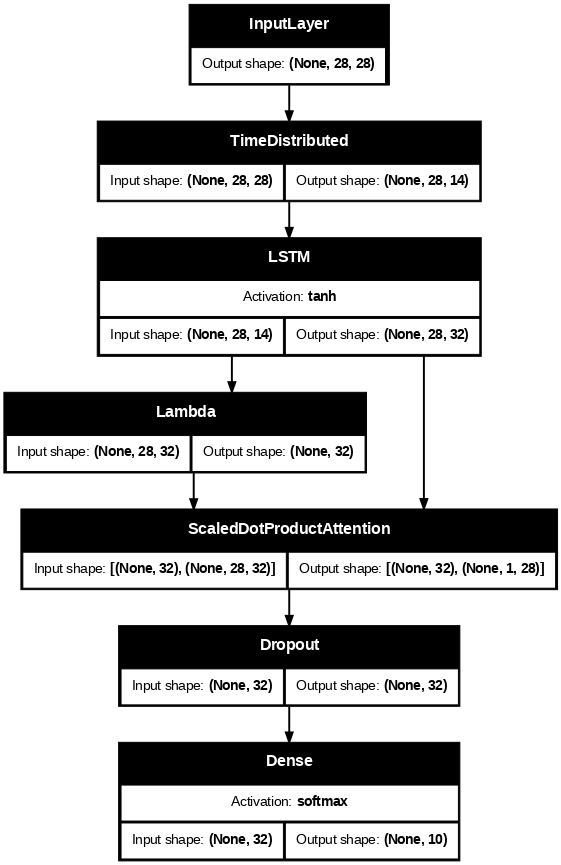

In [32]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=70)

In [33]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

#### Fit

In [34]:
%%time
batch_size = 512
history_3_3 = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size,
                        epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.2174 - loss: 2.1758 - val_acc: 0.4877 - val_loss: 1.5429
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.5769 - loss: 1.3087 - val_acc: 0.7635 - val_loss: 0.7918
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.7824 - loss: 0.7229 - val_acc: 0.8403 - val_loss: 0.5275
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8525 - loss: 0.5018 - val_acc: 0.8847 - val_loss: 0.3941
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8854 - loss: 0.3880 - val_acc: 0.9068 - val_loss: 0.3256
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9046 - loss: 0.3247 - val_acc: 0.9200 - val_loss: 0.2826
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9178 - loss: 0.2862 - val_acc: 0.9281 - val_loss: 0.2480
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9265 - loss: 0.2552 - val_acc: 0.9337 - val_loss: 0.2292
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - a

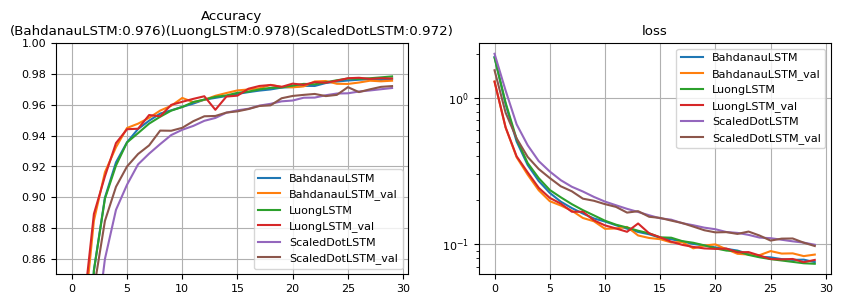

In [35]:
titles=["BahdanauLSTM","LuongLSTM","ScaledDotLSTM"]
plt_history([history_3_1.history,history_3_2.history,history_3_3.history],titles,0.85)

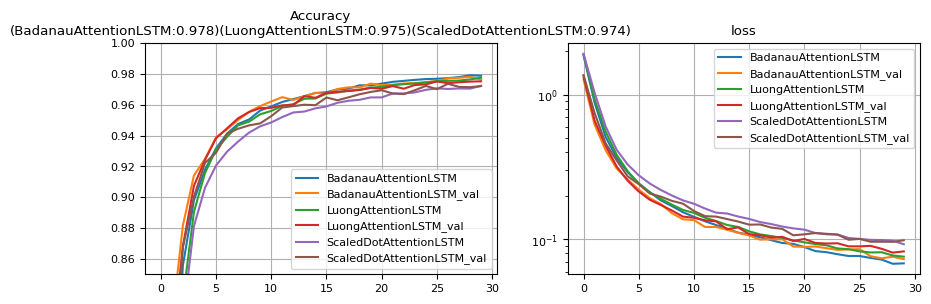

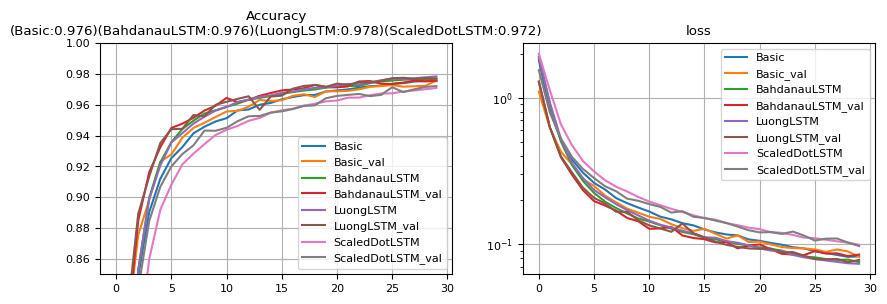

In [36]:
titles=["Basic","BahdanauLSTM","LuongLSTM","ScaledDotLSTM"]
plt_history([history_1.history,history_3_1.history,history_3_2.history,history_3_3.history],titles,0.85)

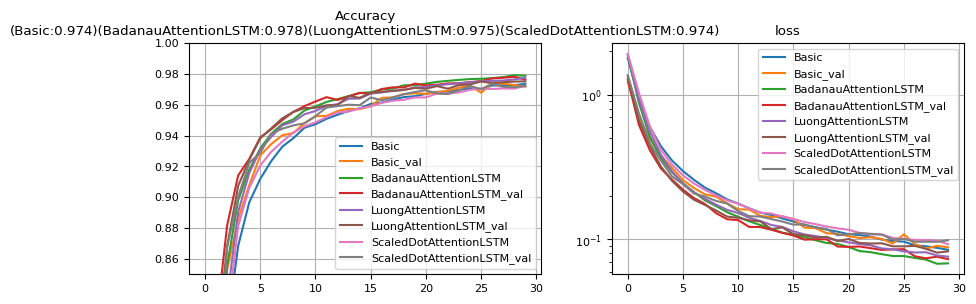

#### Plot Attention Weight(ScaledDotProductAttention)  
* Attention Weight를 출력하도록 모델 수정  

In [37]:
def Attention_lstm_model_attw(hidden_size, num_layers):
    in_layer = keras.Input(shape=(time_steps, features))
    x = in_layer
    for _ in range(num_layers): # x:(bs, time_steps, 2*hidden_size)
        x = layers.Bidirectional(
            layers.LSTM(hidden_size, return_sequences=True, dropout=0.1))(x)
    query = layers.Lambda(lambda t: t[:, -1, :])(x)
    #  Attention 적용
    attention_layer = ScaledDotProductAttention(name="a")
    context_vector, attn_weights = attention_layer(query, x) # (Q,V(K))
    x = layers.Dropout(0.)(context_vector)
    outputs = layers.Dense(out_dense, activation='softmax',name="o")(x)
    model = keras.Model(inputs=in_layer, outputs=[outputs,attn_weights])
    return model

model = Attention_lstm_model_attw( hidden_size=64, num_layers=1)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 28, 128)   │     47,616 │ input_layer_6[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a                   │ [(None, 128),     │          0 │ lambda_3[0][0],   │
│ (ScaledDotProductA… │ (None, 1, 28)]    │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ a[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ o (Dense)           │ (None, 10)        │      1,290 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,906 (191.04 KB)

 Trainable params: 48,906 (191.04 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
#tf.keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=70)

In [39]:
# 두 번째 출력은 dummy loss (0 * y_pred)를 사용합니다.
# 두 번째 출력은 평가 metric 없이 학습됩니다.
model.compile(optimizer='adam',
              loss=['sparse_categorical_crossentropy', lambda y_true, y_pred: 0 * y_pred],
              metrics=[['acc'], []])

#### Fit

In [40]:
%%time
dummy_train = np.zeros((x_train.shape[0], 1, time_steps))
dummy_test = np.zeros((x_test.shape[0], 1, time_steps))

batch_size = 512
model.fit(x_train, [y_train, dummy_train],
                        validation_data=(x_test, [y_test, dummy_test]),
                        batch_size=batch_size,
                        epochs=15)

Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - a_loss: 0.0000e+00 - loss: 1.8802 - o_acc: 0.3591 - o_loss: 1.8801 - val_a_loss: 0.0000e+00 - val_loss: 0.6484 - val_o_acc: 0.7957 - val_o_loss: 0.6532
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - a_loss: 0.0000e+00 - loss: 0.5277 - o_acc: 0.8400 - o_loss: 0.5277 - val_a_loss: 0.0000e+00 - val_loss: 0.2948 - val_o_acc: 0.9165 - val_o_loss: 0.2988
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - a_loss: 0.0000e+00 - loss: 0.2862 - o_acc: 0.9170 - o_loss: 0.2862 - val_a_loss: 0.0000e+00 - val_loss: 0.2157 - val_o_acc: 0.9359 - val_o_loss: 0.2180
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - a_loss: 0.0000e+00 - loss: 0.2137 - o_acc: 0.9370 - o_loss: 0.2137 - val_a_loss: 0.0000e+00 - val_loss: 0.1707 - val_o_acc: 0.9486 - val_o_loss: 0.1734
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - a_loss: 0.0000e+00 - loss: 0.1758 - o_acc: 0.9493 - o_loss: 0.1758 - val_a_loss: 0.0000e+00 - val_loss: 0.1448 - val_o_ac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


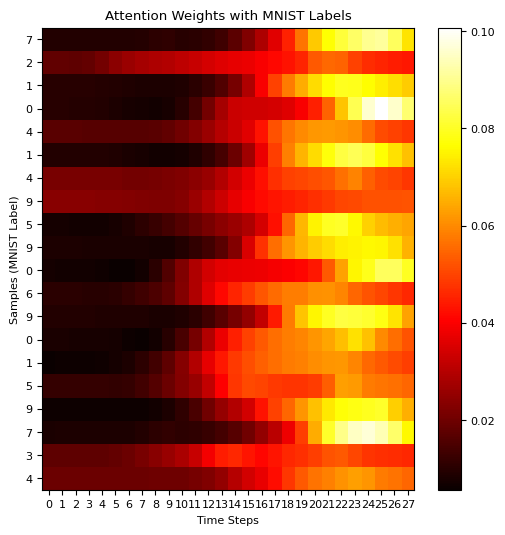

In [41]:
def plot_attention(attention_weights, labels):
    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.imshow(attention_weights, cmap='hot', interpolation='nearest', aspect='auto')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_xticks(range(attention_weights.shape[1]))
    ax.set_xticklabels(range(attention_weights.shape[1]))

    plt.colorbar(cax)
    plt.title("Attention Weights with MNIST Labels")
    plt.xlabel("Time Steps")
    plt.ylabel("Samples (MNIST Label)")
    plt.show()

test_imgs = x_test[0:20]                  # 20개 샘플
true_labels = y_test[0:20]                # 20개 라벨
predictions, attn = model.predict(test_imgs)

attn_squeezed = attn[:, 0, :]  # (batch_size=20, time_steps)

plot_attention(attn_squeezed, true_labels)

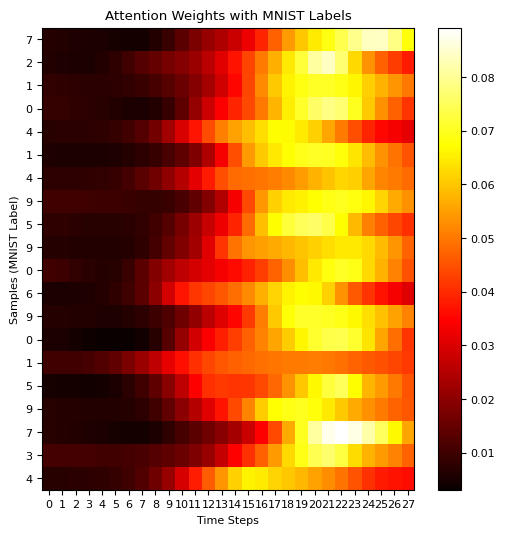

# **실습 과제**  
## 성능의 차이가 구조적은 차이에 있음을 어떻게 확인할 수 있을까 생각해 보고,
## Model-3.1의 크기를 키워, Model-2 크기와 유사하게 Tuning하여 학습해 보자   


In [42]:
## Model-2 설계 : Bidirectional 추가
def model_2():
    model = keras.models.Sequential(name="Bidirectional-RNN")
    model.add(keras.Input(shape=(time_steps, features)))
    model.add(layers.TimeDistributed(layers.Dense(in_dense)))
    model.add(layers.Bidirectional(layers.LSTM(lstm_units,dropout=0.1)))
    model.add(layers.Dense(out_dense, activation='softmax'))
    return model

model = model_2()
model.summary()
# keras.utils.plot_model(model,'model.png',show_shapes=True,dpi=70)


Model: "Bidirectional-RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_6              │ (None, 28, 14)         │           406 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        12,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,088 (51.12 KB)

 Trainable params: 13,088 (51.12 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Bahdanau Attention Layer 정의
class BahdanauAttention(layers.Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.Wq = layers.Dense(units)
        self.Wk = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)  #(bs, 1, units)
        score = self.V(tf.nn.tanh(self.Wq(query_with_time_axis) + self.Wk(values)))
        attention_weights = tf.nn.softmax(score, axis=1) #(bs, time_steps, 1)
        context_vector = tf.reduce_sum(attention_weights*values, axis=1)#(bs, units)
        return context_vector, attention_weights

def Attention_lstm_model(hidden_size, num_layers):
    in_layer = keras.Input(shape=(time_steps, features))
    x = layers.TimeDistributed(layers.Dense(in_dense))(in_layer)
    for _ in range(num_layers):
        x = layers.LSTM(hidden_size, return_sequences=True,dropout=0.1)(x)
    query = layers.Lambda(lambda t: t[:, -1, :])(x) #마지막 timestep:(bs, hidden_size)
    # Attention 적용
    attention_layer = BahdanauAttention(units=hidden_size)
    ## query로 x에서 정보를 취합
    context_vector, attn_weights = attention_layer(query, x) # Att.(Q,V(K))
    x = layers.Dropout(0.)(context_vector)
    outputs = layers.Dense(out_dense, activation='softmax')(x)
    model = keras.Model(inputs=in_layer, outputs=outputs)
    return model

# 모델 생성 및 요약 출력
model = Attention_lstm_model(hidden_size=lstm_units, num_layers=1)
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 28, 14)    │        406 │ input_layer_8[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 28, 32)    │      6,016 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 32)        │          0 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention… │ [(None, 32),      │      2,145 │ lambda_4[0][0],   │
│ (BahdanauAttention) │ (None, 28, 1)]    │            │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ bahdanau_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 10)        │        330 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,897 (34.75 KB)

 Trainable params: 8,897 (34.75 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Bahdanau Attention Layer 정의
class BahdanauAttention_large(layers.Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention_large, self).__init__(**kwargs)
        self.Wq = layers.Dense(units)
        self.Wk = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)  #(bs, 1, units)
        score = self.V(tf.nn.tanh(self.Wq(query_with_time_axis) + self.Wk(values)))
        attention_weights = tf.nn.softmax(score, axis=1) #(bs, time_steps, 1)
        context_vector = tf.reduce_sum(attention_weights*values, axis=1)#(bs, units)
        return context_vector, attention_weights

def Attention_lstm_model_large(hidden_size, num_layers):
    in_layer = keras.Input(shape=(time_steps, features))
    x = layers.TimeDistributed(layers.Dense(in_dense))(in_layer)
    for _ in range(num_layers):
        x = layers.LSTM(hidden_size, return_sequences=True,dropout=0.1)(x)
    query = layers.Lambda(lambda t: t[:, -1, :])(x) #마지막 timestep:(bs, hidden_size)
    # Attention 적용
    attention_layer = BahdanauAttention_large(units=hidden_size*3)
    ## query로 x에서 정보를 취합
    context_vector, attn_weights = attention_layer(query, x) # Att.(Q,V(K))
    x = layers.Dropout(0.)(context_vector)
    outputs = layers.Dense(out_dense, activation='softmax')(x)
    model = keras.Model(inputs=in_layer, outputs=outputs)
    return model

# 모델 생성 및 요약 출력
model = Attention_lstm_model_large(hidden_size=lstm_units, num_layers=1)
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 28, 14)    │        406 │ input_layer_16[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 28, 32)    │      6,016 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 32)        │          0 │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention… │ [(None, 32),      │      6,433 │ lambda_12[0][0],  │
│ (BahdanauAttention… │ (None, 28, 1)]    │            │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32)        │          0 │ bahdanau_attenti… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 10)        │        330 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 13,185 (51.50 KB)

 Non-trainable params: 0 (0.00 B)

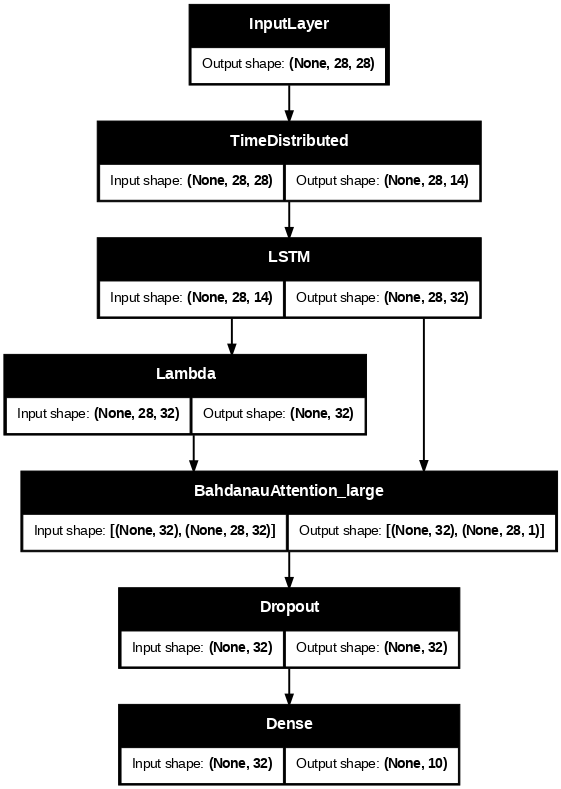

In [53]:
keras.utils.plot_model(model,show_shapes=True,dpi=70)

In [54]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [56]:
%%time
batch_size = 512
history_3_1_1 = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9261 - loss: 0.2653 - val_acc: 0.9358 - val_loss: 0.2297
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9359 - loss: 0.2309 - val_acc: 0.9405 - val_loss: 0.2008
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9421 - loss: 0.2008 - val_acc: 0.9503 - val_loss: 0.1729
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9490 - loss: 0.1802 - val_acc: 0.9524 - val_loss: 0.1618
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9525 - loss: 0.1664 - val_acc: 0.9557 - val_loss: 0.1487
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9551 - loss: 0.1573 - val_acc: 0.9606 - val_loss: 0.1403
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9594 - loss: 0.1430 - val_acc: 0.9622 - val_loss: 0.1297
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9592 - loss: 0.1418 - val_acc: 0.9650 - val_loss: 0.1180
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

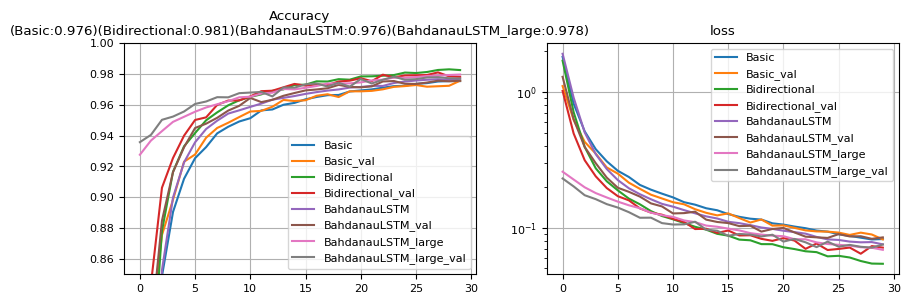

In [58]:
titles=["Basic","Bidirectional", "BahdanauLSTM", "BahdanauLSTM_large"]
plt_history([history_1.history,history_2.history,history_3_1.history, history_3_1_1.history],titles,0.85)

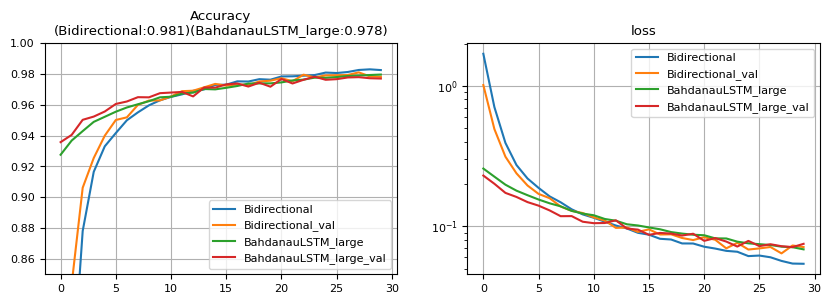

In [61]:
titles=["Bidirectional", "BahdanauLSTM_large"]
plt_history([ history_2.history, history_3_1_1.history],titles,0.85)

- 참조하는 hidden state 크기를 3배로 하여 전체 Parameter 수를 비슷하게 맞췄으나, Bidirectional에 비해 성능 안 좋음